# Data Science Bowl 2017
## Exploratory Data Analysis

Motivation taken from Kaggle users [anokas](https://www.kaggle.com/anokas/data-science-bowl-2017/exploratory-data-analysis) and [Guido Zuidhof](https://www.kaggle.com/gzuidhof/data-science-bowl-2017/full-preprocessing-tutorial)

In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob

%matplotlib inline
p = sns.color_palette()

data_path = '../data/ds-bowl17/'
os.listdir(data_path)

['stage1_sample_submission.csv',
 '.kaggle-cli',
 'stage1_labels.csv',
 'sample_images',
 'stage1']

In [2]:
sample_path = data_path+'sample_images/'
image_path = data_path+'stage1/'
labels_file = data_path+'stage1_labels.csv'

In [3]:
df = pd.read_csv(labels_file)
df.sort_values(by='id')
df.head()

id  cancer
0  0015ceb851d7251b8f399e39779d1e7d       1
1  0030a160d58723ff36d73f41b170ec21       0
2  003f41c78e6acfa92430a057ac0b306e       0
3  006b96310a37b36cccb2ab48d10b49a3       1
4  008464bb8521d09a42985dd8add3d0d2       1

In [4]:
print('Total Number of patients {}, total scans {}'.format(len(os.listdir(image_path)),
                                                   len(glob(image_path+'*/*'))))


def get_num_scans(x):
    return len(os.listdir(image_path+x))

df['num_scans'] = df['id'].apply(get_num_scans)

Total Number of patients 1595, total scans 285380


In [5]:
print('Number of train patients: {}'.format(len(df)))
print('Cancer rate: {:.4}%'.format(df.cancer.mean()*100))

print('Number of test patients: {}'.format(len(os.listdir(image_path))-len(df)))

Number of train patients: 1397
Cancer rate: 25.91%
Number of test patients: 198


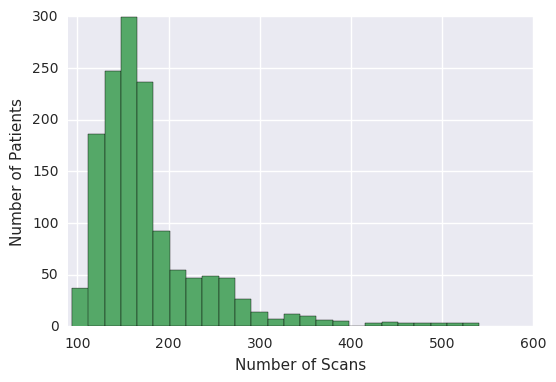

In [6]:
plt.hist(df['num_scans'], 25, color=p[1])
plt.xlabel('Number of Scans')
plt.ylabel('Number of Patients')
plt.xlim([90, 600])
plt.show()

### DICOMS

In [7]:
import dicom

In [8]:
scans = glob(image_path+df.ix[0, 'id']+'/*.dcm')
print('Filename: {}'.format(scans[80]))
dcm = dicom.read_file(scans[0])
dcm

Filename: ../data/ds-bowl17/stage1/0015ceb851d7251b8f399e39779d1e7d/1f3cf2421200d058c30e7a9ed8a76bd0.dcm


(0008, 0000) Group Length                        UL: 358
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.7009.9004.193705497713421423972698394036
(0008, 0060) Modality                            CS: 'CT'
(0008, 103e) Series Description                  LO: 'Axial'
(0010, 0000) Group Length                        UL: 64
(0010, 0010) Patient's Name                      PN: '0015ceb851d7251b8f399e39779d1e7d'
(0010, 0020) Patient ID                          LO: '0015ceb851d7251b8f399e39779d1e7d'
(0010, 0030) Patient's Birth Date                DA: '19000101'
(0018, 0060) KVP                                 DS: ''
(0020, 0000) Group Length                        UL: 392
(0020, 000d) Study Instance UID                  UI: 2.25.51820907428519808061667399603379702974102486079290552633235
(0020, 000e) Series Instance UID           

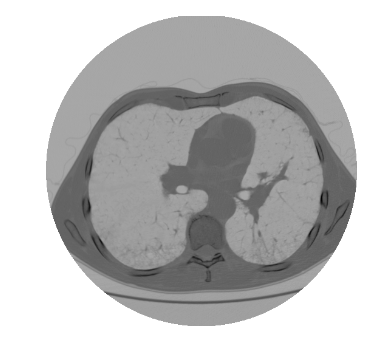

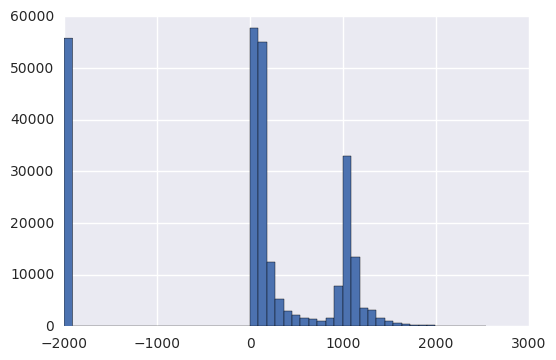

In [9]:
img = dcm.pixel_array
plt.imshow(img, cmap=plt.cm.bone)
plt.axis('off')
plt.show()

plt.hist(img.flatten(), bins=50)
plt.show()

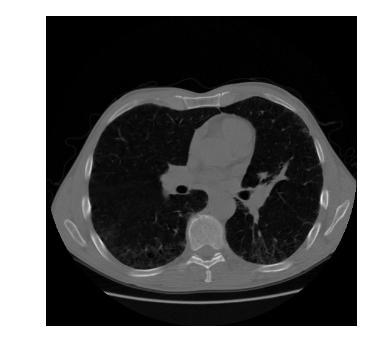

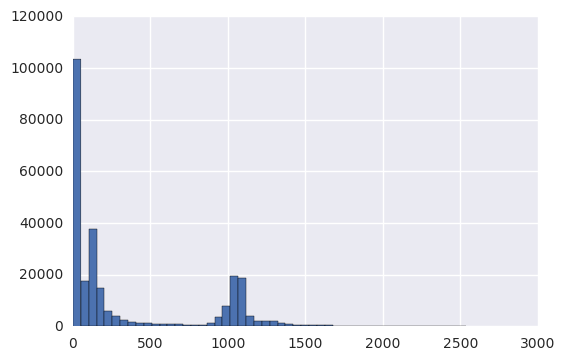

In [10]:
# remove -2000 pixels and set to 0
img[img == -2000] = 0

img = dcm.pixel_array
plt.imshow(img, cmap=plt.cm.bone)
plt.axis('off')
plt.show()

plt.hist(img.flatten(), bins=50)
plt.show()

In [11]:
# load scan for one patient and do some preprocessing
def load_scan(scan_path):
    slices = [dicom.read_file(scan_path + '/' + s) for s in os.listdir(scan_path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    
    slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
 
    for i in range(0, len(slices)):
        slices[i].SliceThickness = slice_thickness
        img = slices[i].pixel_array.astype(int)
        img[img == -2000] = 0
        img += int(slices[0].RescaleIntercept)
        slices[i].scaled_pixels = img
        
    return slices

def slices_pixels(slices):
    return np.stack([s.scaled_pixels for s in slices])

def slices_thickness(slices):
    thick = np.zeros(len(slices))
    for i in range(0, len(slices)):
        thick[i] = slices[i].SliceThickness
    return thick

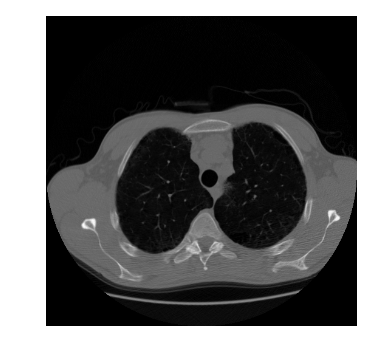

In [12]:
scan0 = load_scan(image_path + df.ix[0, 'id'])
plt.imshow(scan0[150].scaled_pixels, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

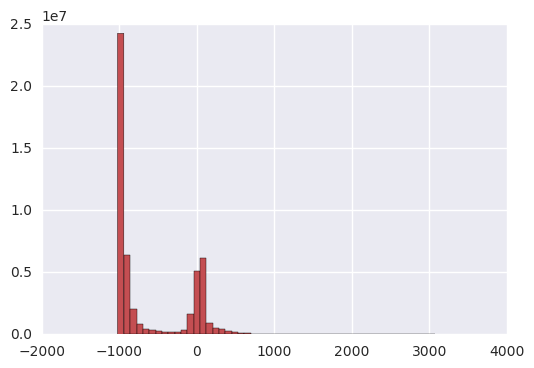

In [14]:
scan0_pixels = slices_pixels(scan0)
plt.hist(scan0_pixels.flatten(), bins=50, color=p[2])
plt.show()

In [15]:
def get_spacing(id):
    scan_path = image_path+id
    slices = [dicom.read_file(scan_path + '/' + s) for s in os.listdir(scan_path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    
    return np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])

df['spacing'] = df['id'].apply(get_spacing)

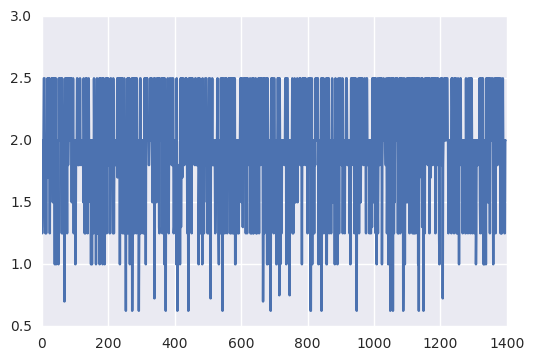

In [16]:
plt.plot(df['spacing'])

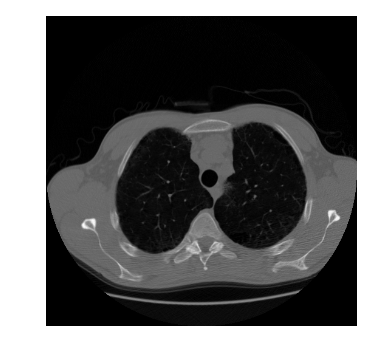

In [31]:
scan = load_scan(image_path + df.ix[1, 'id'])
plt.imshow(scan0[150].scaled_pixels, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

full_img = slices_pixels(scan)

In [32]:
full_img.shape

(265, 512, 512)

In [33]:
from IPython.display import HTML
import matplotlib.animation as animation

def animate_z(img3d):
    fig = plt.figure()
    plt.axis('off')
    im = plt.imshow(img3d[0, :, :], cmap=plt.cm.bone, animated=True);
    def update(i):
        im.set_array(img3d[i, :, :])
        return im,
    
    ani = animation.FuncAnimation(fig, update, frames=img3d.shape[0], interval=50, blit=True)
    plt.close()
    
    return ani
   
anim = animate_z(full_img);
HTML(anim.to_html5_video())

In [34]:
def animate_x(img3d):
    fig = plt.figure()
    plt.axis('off')
    im = plt.imshow(img3d[:, 0, :], cmap=plt.cm.bone, animated=True);
    def update(i):
        im.set_array(img3d[:, 3*i, :])
        return im,
    
    ani = animation.FuncAnimation(fig, update, frames=img3d.shape[1] // 3, interval=50, blit=True)
    plt.close()
    
    return ani
   
anim = animate_x(full_img);
HTML(anim.to_html5_video())

In [35]:
def animate_y(img3d):
    fig = plt.figure()
    plt.axis('off')
    im = plt.imshow(img3d[:, :, 0], cmap=plt.cm.bone, animated=True);
    def update(i):
        im.set_array(img3d[:, :, 3*i])
        return im,
    
    ani = animation.FuncAnimation(fig, update, frames=img3d.shape[2] // 3, interval=50, blit=True)
    plt.close()
    
    return ani
   
anim = animate_y(full_img);
HTML(anim.to_html5_video())

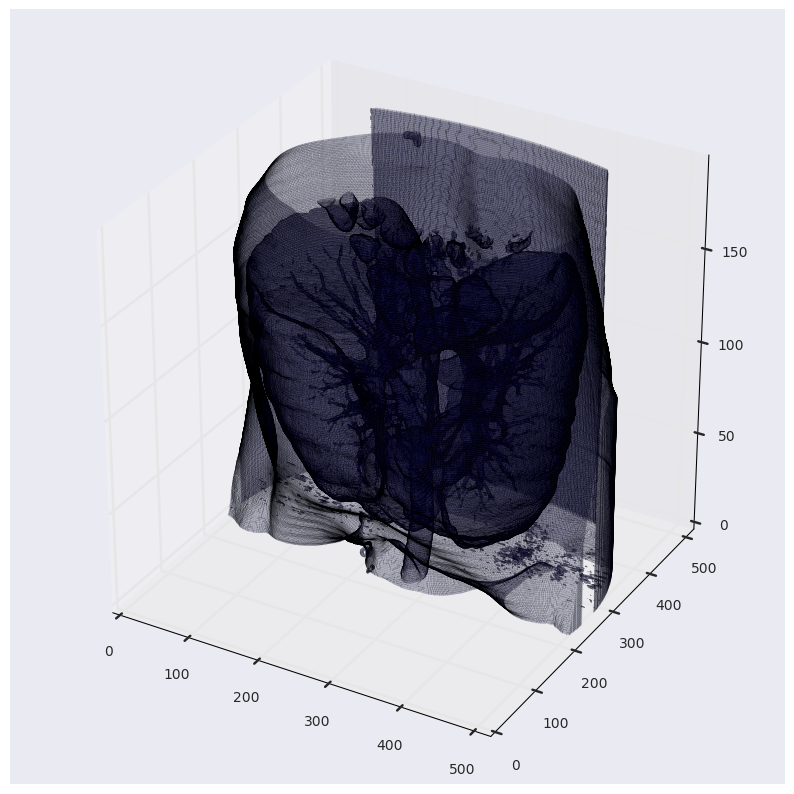

In [29]:
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    p = p[:,:,::-1]
    
    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()
    
plot_3d(full_img)

## Sample Submission

Dumb submission where predict every patient has 25% chance of cancer